# Predicting Evergreeness of Content with Decision Trees and Random Forests

Author: Arun Ahuja, James Larkin, et al.


#### A note on packages in this notebook
If you want to give this full notebook a try you will need to install the following from command line:    
- conda install graphviz  
- conda install pydotplus 

Don't feel like it?  
No problem, comment out import pydotplus import in cell 1 and the graphviz code block in cell 25 

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import tree
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
import pydotplus
 
# Read in the stumbleupon.tsv data - notice the use of the "sep" parameter here.
# This is tab-separated file and not a comma-separated file, so the "sep"
# parameter is set to "\t" to denote tab.
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
data = pd.read_csv("../../assets/dataset/stumbleupon.tsv", sep='\t')
data['title'] = data.boilerplate.map(lambda x: json.loads(x).get('title', ''))
data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', ''))
data.head(2)

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,title,body
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,...,24,0,5424,170,8,0.152941,0.079130,0,IBM Sees Holographic Calls Air Breathing Batte...,A sign stands outside the International Busine...
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,...,40,0,4973,187,9,0.181818,0.125448,1,The Fully Electronic Futuristic Starting Gun T...,And that can be carried on a plane without the...


In [2]:
# Check the dimensions of your new dataset
data.shape

(7395, 29)

In [3]:
# Check for missing values
data.isnull().sum()[data.isnull().sum() != 0].sort_values(ascending=False)

body     57
title    12
dtype: int64

In [4]:
# Address missing values by dropping rows with missing values
data.dropna(inplace=True)

In [5]:
# Spot check your work
data.isnull().sum()[data.isnull().sum() != 0]

Series([], dtype: int64)

## Predicting "Greenness" Of Content

This dataset comes from [stumbleupon](https://www.stumbleupon.com/), a web page recommender. A description of the columns is below:

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
title|string|Title of the article
body|string|Body text of article
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonlinkratio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonlinkratio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonlinkratio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonlinkratio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

### What are "evergreen" sites?

> #### Evergreen sites are those that are always relevant.  As opposed to breaking news or current events, evergreen websites are relevant no matter the time or season. 

> #### A sample of URLs below where label = 1 are "evergreen" websites

In [6]:
data[['url', 'label']].head()

,url,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,0
1,http://www.popsci.com/technology/article/2012-...,1
2,http://www.menshealth.com/health/flu-fighting-...,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,1
4,http://bleacherreport.com/articles/1205138-the...,0


### Exercises to Get Started

 ### Exercise: 1. In a group: Brainstorm 3 - 5 features you could develop that would be useful for predicting evergreen websites.
 ###  Exercise: 2. After looking at the dataset, can you model or quantify any of the characteristics you wanted?
- If you believe high-image content websites are likely to be evergreen, how can you build a feature that represents that?
- If you believe weather content is likely NOT to be evergreen, how might you build a feature that represents that?

### Split up and develop 1-3 of those features independently.

### Exercise: 3. Does being a news site affect evergreeness? 
Compute and/or plot the percentage of news related evergreen sites.

In [7]:
import seaborn as sb
%matplotlib inline
# data.is_news.value_counts()

# is_news = True (1) if StumbleUpon's news classifier determines that this webpage is news

# Option 1: Find out P ( evergreen | is_news = 1) vs P ( evergreen | is_news = ?)

data.groupby(['is_news'])[['label']].mean()

,label
is_news,
1,0.516545
?,0.509207


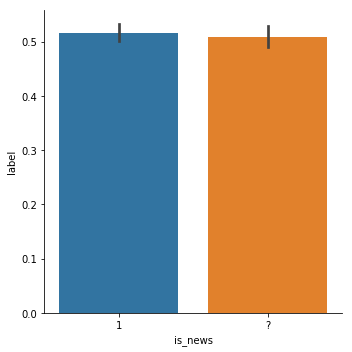

In [10]:
# A visualized version of the output above
sns.catplot(x='is_news', y='label', kind='bar', data = data);

### Exercise: 4. Does category in general affect evergreeness? 

Plot the rate of evergreen sites for all Alchemy categories.

In [11]:
data.groupby(['alchemy_category'])[['label']].mean()[:5]

,label
alchemy_category,
?,0.501512
arts_entertainment,0.370847
business,0.715110
computer_internet,0.247458
culture_politics,0.461538


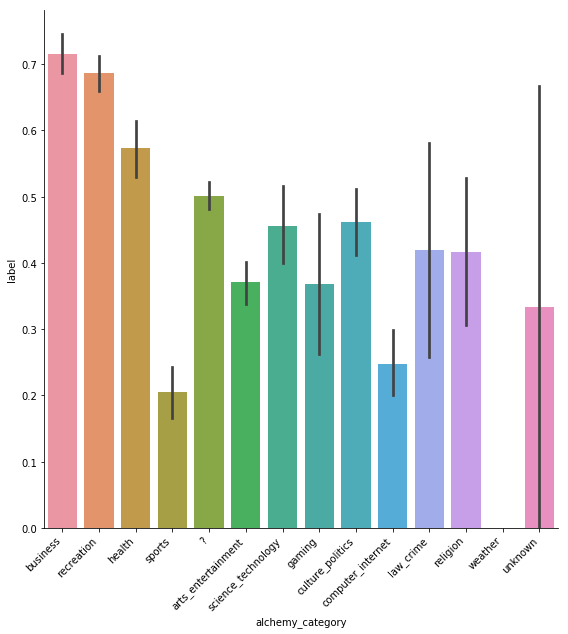

In [13]:
# Plot that output from above

p = sns.catplot(x='alchemy_category', y='label', kind='bar', data = data, height = 8)
p.set_xticklabels(rotation=45, horizontalalignment='right');

### Exercise: 5. How many articles are there per category?

In [14]:
data.groupby(['alchemy_category'])[['label']].count()[:5]

,label
alchemy_category,
?,2315
arts_entertainment,933
business,867
computer_internet,295
culture_politics,338


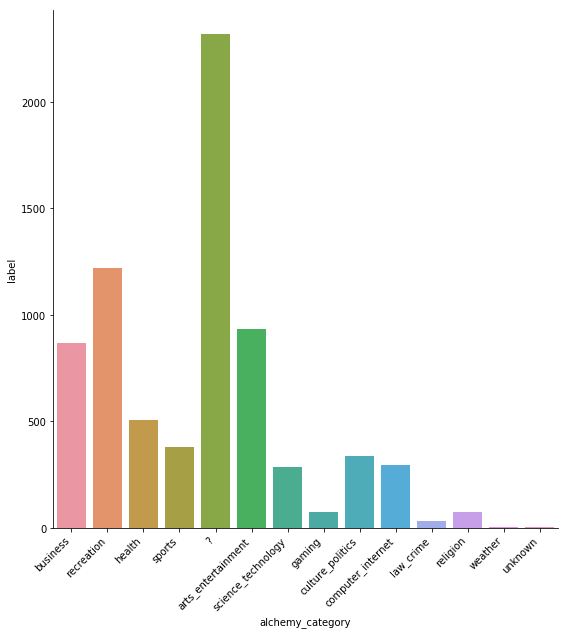

In [15]:
p = sns.catplot(x='alchemy_category', y='label', kind='bar', data = data,
                 height = 8, estimator=len)
p.set_xticklabels(rotation=45, horizontalalignment='right');

> #### Let's try extracting some of the text content.
> ### Exercise: 6. Create a feature for the title containing 'recipe'. 
Is the % of evegreen websites higher or lower on pages that have recipe in the the title?

In [16]:
# Option 1: Create a function to check for this

# Try/Except: If an error is encountered, the try block code execution
# is stopped and transferred down to the except block.

def has_recipe(text_in):
    try:
        if 'recipe' in str(text_in).lower():
            return 1
        else:
            return 0
    except: 
        return 0

# Map our newly created function to the title column in our dataset
# and assign the output of 1's and 0's to a new data column "recipe"
data['recipe'] = data['title'].map(has_recipe)

# Option 2: lambda functions

#data['recipe'] = data['title'].map(lambda t: 1 if 'recipe' in str(t).lower() else 0)

# Option 3: string functions

# Similar to above but the output will be bools 
# (true/false) instead of 1's and 0's.

#data['recipe'] = data['title'].str.contains('recipe')

In [17]:
# In this newly created column, check to see how
# many pages had recipe in the the title.
data.recipe.value_counts()

0    6399
1     928
Name: recipe, dtype: int64

## Decision Trees in scikit-learn

###  Let's Explore Some Decision Trees:

`In essence, decision trees are just a sequence of "if this, then that" conditions.`

`1. They are non-parametric (no assumptions about the distribution(s) of your data).`<br>
`2. No coefficients`

 ### Demo: Build a decision tree model to predict the "evergreeness" of a given website. 

In [18]:
# Import the DecisionTree Classifier from scikit's tree module
from sklearn.tree import DecisionTreeClassifier

# Instantiate your dtc object as assign it to the variable name "model"
model = DecisionTreeClassifier()

# Select your features
X = data[['image_ratio', 'html_ratio', 'recipe']]

# Set your target variable
y = data['label']
    
    
# Fit the model
model.fit(X, y)

# Helper function to visualize Decision Trees (creates a file tree.png)
from sklearn.tree import export_graphviz
from os import system 
def build_tree_image(model):
    dotfile = open("tree.dot", 'w')
    export_graphviz(model, out_file = dotfile, feature_names = X.columns)
    dotfile.close()
    system("dot -Tpng tree.dot -o tree.png")
    
build_tree_image(model)

### Now we're going to take a sample of our data and attempt to visualize it right inside the notebook.

`The full X and y would not output in Jupyter notebook. Attempts were a real kernel killer.`

### The way a decision tree works is that it attempts to find the decision that will best segregate the classes.

`When entropy is 1, the classes are balanced and when entropy is 0 everything is the same class.` 

In [19]:
#graph_model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)
graph_model = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Setting class_weight to 'balanced' will replicate the 
# minority class until the two classes have equal representation

# When proportion=True, the output is the fraction of records 
# for each class that have reached that node.

graph_X = X[:200]
graph_y = y[:200]

In [20]:
print(graph_X.shape)
print(graph_y.shape)

(200, 3)
(200,)


In [21]:
graph_model.fit(graph_X, graph_y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [22]:
graph_model.score(X,y)

0.545380100996315

In [23]:
dot_data = tree.export_graphviz(graph_model, out_file=None, feature_names=X.columns,
                                filled=True, rounded=True, special_characters=True) 
graph = pydotplus.graphviz.graph_from_dot_data(dot_data)
# Image(graph.create_png())

`If we don't put any limits on the decision tree classifier, what do you see? It just continues splitting until entropy is zero (all examples in that node are in the same class).` 

`Q: Why might that be a problem?`

`A. Overfitting. A common problem with decision trees.`

 ### Demo: Evaluate the decision tree we just created using cross-validation; use AUC as the evaluation metric.

In [24]:
from sklearn.model_selection import cross_val_score

# dtc is the estimator or the object to used to fit the data.
# X is your features, y is your target. You then select a scoring method -
# here we choose area under the curve as the evaluation metric. 
# cv: the number of folds (default is 3)
scores = cross_val_score(model, graph_X, graph_y, scoring='roc_auc', cv=5)
print('CV AUC {}, \nAverage AUC {}'.format(scores, scores.mean()))

CV AUC [0.55072464 0.50383632 0.56905371 0.5971867  0.51737968], 
Average AUC 0.5476362086336511


`How we can address overfitting concerns?` 

###  Adjusting Decision Trees to Avoid Overfitting:

DecisionTreeClassifier(): This is the classifier function for DecisionTree. It is the main function for implementing the algorithms. Some important parameters are:

- **criterion**: It defines the function to measure the quality of a split. Sklearn supports “gini” criteria for Gini Index & “entropy” for Information Gain. By default, it takes “gini” value.
- **splitter**: It defines the strategy to choose the split at each node. Supports “best” value to choose the best split & “random” to choose the best random split. By default, it takes “best” value.
- **max_features**: It defines the no. of features to consider when looking for the best split. We can input integer, float, string & None value.
If an integer is inputted then it considers that value as max features at each split.
If float value is taken then it shows the percentage of features at each split.
If “auto” or “sqrt” is taken then max_features=sqrt(n_features).
If “log2” is taken then max_features= log2(n_features).
If None, then max_features=n_features. By default, it takes “None” value.
- **max_depth**: The max_depth parameter denotes maximum depth of the tree. It can take any integer value or None. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. By default, it takes “None” value.
- **min_samples_split**: This tells above the minimum no. of samples reqd. to split an internal node. If an integer value is taken then consider min_samples_split as the minimum no. If float, then it shows percentage. By default, it takes “2” value.
- **min_samples_leaf**: The minimum number of samples required to be at a leaf node. If an integer value is taken then consider min_samples_leaf as the minimum no. If float, then it shows percentage. By default, it takes “1” value.
- **max_leaf_nodes**: It defines the maximum number of possible leaf nodes. If None then it takes an unlimited number of leaf nodes. By default, it takes “None” value.
- **min_impurity_split**: It defines the threshold for early stopping tree growth. A node will split if its impurity is above the threshold otherwise it is a leaf.

 ### Demo: Control for overfitting in the decision model by adjusting the maximum number of questions (max_depth) or the minimum number of records in each final node (min_samples_leaf)

In [25]:
# Instantiating a Decision Tree Classifier with explicit setting of max_depth=2 
# (instead of the default which is max_depth=None) and explicit setting of 
# min_samples_leaf=5 (instead of the default which is min_samples_leaf=2)
model = DecisionTreeClassifier(max_depth=2, min_samples_leaf=5)

# Fit your model
model.fit(X, y)
build_tree_image(model)

 ### Demo: Build a random forest model to predict the evergreeness of a website. 

In [26]:
# Import RandomForestClassifier from scikit's ensemble module
from sklearn.ensemble import RandomForestClassifier

# Instanitate your Random Forest Classifier model object with n_estimators or
# the number of trees in the forest set to 20 (default is 10)
model = RandomForestClassifier(n_estimators = 20)

# Fit your model on the features (X) and the target (y)
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Demo: Extracting importance of features

In [27]:
# Set features variable with the names of the features in X
features = X.columns
print("Feature columns:", features)

# Set feature_importances variable using the attribute "feature_importances_".
# The higher the score, the more important the feature in that particular combination.
# If you changed the features in X it would impact the scores. Similar to coefficients.
feature_importances = model.feature_importances_
print("Feature Importance scores:", feature_importances)

# Create a dataframe of the features and their respective importance scores
features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})

# Sort the values by "Importance Score" with ascending in false to ensure
# the score appear from highest to lowest in the new dataframe
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df

Feature columns: Index(['image_ratio', 'html_ratio', 'recipe'], dtype='object')
Feature Importance scores: [0.40829483 0.5022538  0.08945137]


,Features,Importance Score
1,html_ratio,0.502254
0,image_ratio,0.408295
2,recipe,0.089451


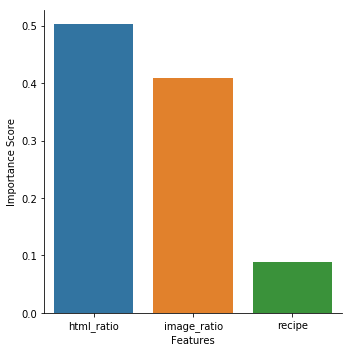

In [28]:
# Seaborn's factorplot draws a categorical plot onto a FacetGrid WITH COLORS!
sns.catplot(x='Features', y='Importance Score', kind='bar', data = features_df);

 ### Demo: Evaluate the Random Forest model using cross-validation; increase the number of estimators and view how that improves predictive performance.

In [30]:
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
# cross_val_score(estimator, features, target, chosen scoring method) assigned to the variable "scores."
# scores will be a numpy array
scores = cross_val_score(model, X, y, cv=3, scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

# A for loop for running a Random Forest Classifier with n-estimators (or number of trees in your forest).
# The is 1 to 100 in steps of 10 - range(start, end, step)
for n_trees in range(1, 100, 10):
    model = RandomForestClassifier(n_estimators = n_trees)
    scores = cross_val_score(model, X, y, cv=3, scoring='roc_auc')
    print('n trees: {}, CV AUC {}, Average AUC {}'.format(n_trees, scores, scores.mean()))

CV AUC [0.61779951 0.63985204 0.6343502 ], Average AUC 0.6306672486668004
n trees: 1, CV AUC [0.54973205 0.58012227 0.57519627], Average AUC 0.5683501972570856
n trees: 11, CV AUC [0.60775652 0.63282023 0.62342879], Average AUC 0.6213351784989339
n trees: 21, CV AUC [0.61183985 0.63115384 0.62601461], Average AUC 0.6230027650757007
n trees: 31, CV AUC [0.61336674 0.63490952 0.63145634], Average AUC 0.626577531933686
n trees: 41, CV AUC [0.61926939 0.64035105 0.63785306], Average AUC 0.6324911660128928
n trees: 51, CV AUC [0.62242377 0.6375052  0.62944156], Average AUC 0.6297901762834873
n trees: 61, CV AUC [0.61569245 0.63841301 0.63119635], Average AUC 0.6284339368629147
n trees: 71, CV AUC [0.61318262 0.6414232  0.63517116], Average AUC 0.6299256594208035
n trees: 81, CV AUC [0.61422995 0.6398668  0.6339246 ], Average AUC 0.6293404482797048
n trees: 91, CV AUC [0.6179578  0.64279213 0.63283458], Average AUC 0.6311948350332525


##  Independent Practice: Evaluate Random Forest Using Cross-Validation

1. Continue adding input variables to the model that you think may be relevant
2. For each feature:
  - Evaluate the model for improved predictive performance using cross-validation
  - Evaluate the _importance_ of the features and create a quick plot to visually express the _importance_ of those features
3. **Bonus**: Just like the `recipe` feature, add in similar **text** features and evaluate their performance.

### 1. Build a model with more relevant features

In [31]:
## 1. Building a model with more relevant features

model = RandomForestClassifier(n_estimators=50)

# Continue to add features to X
# Consider building dummy features, include quantitative features, or add text features
X = data[['image_ratio', 'html_ratio', 'recipe',]] # <- more features here? 
y = data['label']

# Fit a model on the whole dataset
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### 2a. Evaluate predictive performance for the given feature set

`Here's an example from some ship people won't stop talking about:`

`scores = cross_validation.cross_val_score(model, titanic[features] (or X), titanic[target] (or y), cv=10)`

In [32]:
scores = cross_val_score(model, X, y, cv=3, scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [0.61460086 0.64185682 0.63491788], Average AUC 0.6304585182215942


### 2b. Evaluating feature importances 

`If unsure how to proceed, review the demo earlier in the notebook regarding extracting the importance of features and the subsequent use of seaborn to visually display those feature importances.`

In [33]:
# Get columns and their scores
features = X.columns
feature_importances = model.feature_importances_
features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df.head()

,Features,Importance Score
1,html_ratio,0.495303
0,image_ratio,0.415289
2,recipe,0.089408


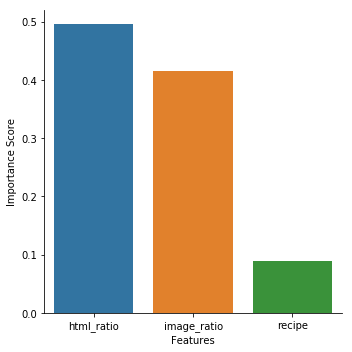

In [34]:
# Seaborn's factorplot STILL draws a categorical plot onto a FacetGrid WITH COLORS!
# What a time to be alive!
sns.catplot(x='Features', y='Importance Score', kind='bar', data = features_df);

### 3. BONUS!!! Add in text features (strings, objects) and do it all over again!

`How many text columns options do you have?`

In [35]:
data.get_dtype_counts()

float64    12
int64      10
object      8
dtype: int64

`What are your text column options`

In [36]:
#data.loc[:, data.dtypes == object].columns
data.select_dtypes(exclude=[np.number]).columns

Index(['url', 'boilerplate', 'alchemy_category', 'alchemy_category_score',
       'is_news', 'news_front_page', 'title', 'body'],
      dtype='object')

### Create a new model with text features or many text features

In [37]:
# Check for keywords in the title
data['PhotoInTitle'] = data['title'].fillna('').str.lower().str.contains('photo').astype(int)

# New X with an additional feature
X = data[['image_ratio', 'html_ratio', 'recipe', 'PhotoInTitle']]

# Still the same target variable "label"
y = data['label']

# Fit a model on the whole dataset
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Evaluate your new text-inclusive model

In [39]:
# cross_val_score(estimator, features, target, chosen scoring method) assigned 
# to the variable "scores, which will be a numpy array.
scores = cross_val_score(model, X, y, cv=3, scoring='roc_auc')
print('With additional text column(s): \nCV AUC {}, Average AUC {}'.format(scores, scores.mean()))

With additional text column(s): 
CV AUC [0.61104773 0.64395851 0.64287994], Average AUC 0.6326287247878054


### Find and visually express the feature importances of your new model

In [40]:
# Get columns and their scores
features = X.columns
feature_importances = model.feature_importances_
features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df.head()

,Features,Importance Score
1,html_ratio,0.492670
0,image_ratio,0.409711
2,recipe,0.092534
3,PhotoInTitle,0.005085


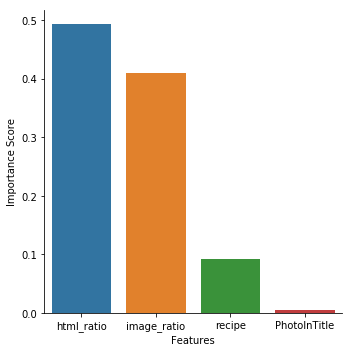

In [41]:
# Seaborn's factorplot STILL draws a categorical plot onto a FacetGrid WITH COLORS!
# What a time to be alive!
sns.catplot(x='Features', y='Importance Score', kind='bar', data = features_df);

### BUT WAIT, THERE'S MORE BONUSES! 

<a href="https://imgflip.com/i/253hro"><img src="https://i.imgflip.com/253hro.jpg" title="made at imgflip.com"/></a>

### You can also tune your Random Forest Classifier hyperparameters using GridsearchCV!

You can find parameter options here: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

`Here's an example of gridsearchCV parameter dictionary from good old kNN:`

`knn_dict = {
    'n_neighbors': [10, 12, 14, 16],
    'p': [1, 2],
    'weights': ['uniform', 'distance']}`


In [42]:
# Import GridSearchCV from sklearn's model selection library
from sklearn.model_selection import GridSearchCV

print('Processing GridSearch. Please hold for the next available set of outputs.\n')
parameters = {"max_depth": [2,3,4,5,6,7,8,9,10,11,12]
             ,"min_samples_split" :[2,3,4,5,6]
             ,"n_estimators" : [10]
             ,"min_samples_leaf": [1,2,3,4,5]
             ,"criterion": ('gini','entropy')}

rf = RandomForestClassifier(random_state=42)
gd_model = GridSearchCV(rf, parameters, n_jobs = -1, cv=10)
gd_model.fit(X,y)

print(gd_model.best_params_)
#print(gd_model.best_estimator_)
print(gd_model.best_score_)

Processing GridSearch. Please hold for the next available set of outputs.

{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 10}
0.6100723351985806


### Classification not for you? Fancy yourself a regression aficionado? 
### That's just fine! Scikit's got your back.

`The Ames Housing Training and Test .csvs are available for you explore the Regressor versions of Decision Trees
and Random Forests.`

http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
    
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [37]:
# Import libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [38]:
# Load data
ames_train = pd.read_csv("../../assets/dataset/Ames_train.csv")
ames_test = pd.read_csv("../../assets/dataset/Ames_test.csv")